### Table of Contents <a class="anchor" id="part0"></a>

* [Linear Regression](#part1)
    * [EDA](#section_1_1)
    * [Feature Selection and Engineering](#section_1_2)
    * [Buliding a Linear Regression model](#section_1_3)
    * [Testing Remaining LR Assumptions](#section_1_4)
* [Logistic Regression](#part2)  


    

# Linear Regression <a class="anchor" id="part1"></a>
## EDA <a class="anchor" id="section_1_1"></a>

### Project Description:
Using Hyundai Heavy Industries ships datasets, build a model that will predict the number of crew members a ship will require.  
Data description: Measurements of ship tonnage (1000s), length(100's ft), passengers (100s), cabins (100s), crew (100s), and age for 158 cruise ships.

In [167]:
#imports

from pyspark.sql import SparkSession
import pandas as pd
import numpy as np

#statistical tests:
from pyspark.mllib.stat import Statistics
from statsmodels.stats.stattools import durbin_watson
from pyspark.sql.functions import udf


#data prep/EDA:
from pandas.plotting import scatter_matrix
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import PCA
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql import Window
import pyspark.sql.functions as F

#building regression:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import DenseVector
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
spark = SparkSession.builder.appName("Ship_Regression").getOrCreate()
spark.sparkContext.setLogLevel('OFF')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/03 10:47:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
ship_data = spark.read.csv('/Users/test/Desktop/Data_Science/Apache Spark/Python-and-Spark-for-Big-Data-master/\
Spark_for_Machine_Learning/Linear_Regression/cruise_ship_info.csv', inferSchema=True, header=True)

In [4]:
ship_data.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

In [5]:
ship_data.printSchema()
#from what we can see all data is in integer format except ship name and cruise line. 
#Ship name does not have predictive value as it's arbitrary, we will not be using it in our model.

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [6]:
#checking for Nan values - there is none which makes it much easier to work with
ship_data.select([count(when(isnan(c), c)).alias(c) for c in ship_data.columns]).show()

+---------+-----------+---+-------+----------+------+------+-----------------+----+
|Ship_name|Cruise_line|Age|Tonnage|passengers|length|cabins|passenger_density|crew|
+---------+-----------+---+-------+----------+------+------+-----------------+----+
|        0|          0|  0|      0|         0|     0|     0|                0|   0|
+---------+-----------+---+-------+----------+------+------+-----------------+----+



In [7]:
# checking what values we can find in "Cruis_Line" column
ship_data.select(ship_data['Cruise_Line']).distinct().show()

+-----------------+
|      Cruise_Line|
+-----------------+
|            Costa|
|              P&O|
|           Cunard|
|Regent_Seven_Seas|
|              MSC|
|         Carnival|
|          Crystal|
|           Orient|
|         Princess|
|        Silversea|
|         Seabourn|
| Holland_American|
|         Windstar|
|           Disney|
|        Norwegian|
|          Oceania|
|          Azamara|
|        Celebrity|
|             Star|
|  Royal_Caribbean|
+-----------------+



In [8]:
#stats for numeric columns:
num_cols = ship_data.select(ship_data.columns[2:])
for col in num_cols.columns:
    ship_data.describe(col).show()
#from the stats below we can see that there is a big difference in max/min values of tonnage - we may need 
#to treat them as outliers. There is also a difference in scale. We will fix this by normalizing data

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|               158|
|   mean|15.689873417721518|
| stddev| 7.615691058751413|
|    min|                 4|
|    max|                48|
+-------+------------------+

+-------+------------------+
|summary|           Tonnage|
+-------+------------------+
|  count|               158|
|   mean| 71.28467088607599|
| stddev|37.229540025907866|
|    min|             2.329|
|    max|             220.0|
+-------+------------------+

+-------+-----------------+
|summary|       passengers|
+-------+-----------------+
|  count|              158|
|   mean|18.45740506329114|
| stddev|9.677094775143416|
|    min|             0.66|
|    max|             54.0|
+-------+-----------------+

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|              158|
|   mean|8.130632911392404|
| stddev|1.793473548054825|
|    min|             2.79|
|    max|            11.82|

In [16]:
num_cols = num_cols.toPandas()

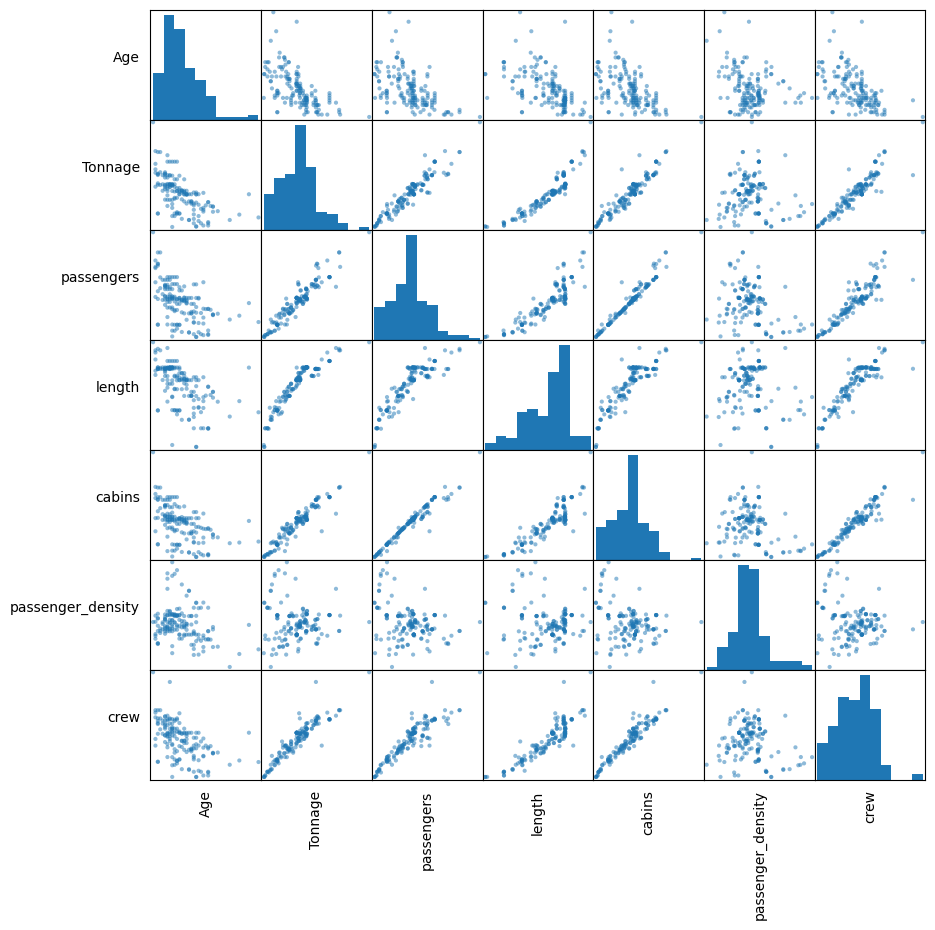

In [17]:
#investigating if relationship between dependent variable and numerical features is linear:
axs = scatter_matrix(num_cols, figsize=(10, 10))
n = len(num_cols.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

From what we can see, all features have a linear relationship with the target, except passenger_density
we will assess if there is correlation using Spearman's coefficient, since the relatioship is non-linear

### [Back to table of Contents](#part0)

## Feature Selection and Engineering <a class="anchor" id="section_1_2"></a>

In [18]:
corr_df = num_cols[['crew', 'passenger_density']]
corr_df = spark.createDataFrame(corr_df)

/opt/anaconda3/envs/pyspark/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/anaconda3/envs/pyspark/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [19]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
vector_col = 'corr_feat'
assembler = VectorAssembler(inputCols=corr_df.columns, outputCol=vector_col)
df_vector = assembler.transform(corr_df).select(vector_col)

In [20]:
matrix = Correlation.corr(df_vector, vector_col, method = 'spearman')
corr_mtx = matrix.collect()[0][matrix.columns[0]].toArray()
corr_mtx
#from what we can see, there is not much correlation between passenger density and # 
#of crew members, we can remove this feature

array([[ 1.        , -0.05889362],
       [-0.05889362,  1.        ]])

In [ ]:
num_cols = num_cols.drop(columns = ['passenger_density'])
num_cols

In [23]:
#calculating vif to assess multicollinearity. We expect it to be  a problem in our model, 
#since many variables are a reflection on the size of the ship

def vif(features):
    col_names=features.columns
    vif_col_name = []
    vif_val = []
    
    for i in range(len(col_names)):
       
        train = features.rdd.map(lambda x: [Vectors.dense(x[:i]+x[i+1:]), x[i]]).toDF(['features', 'label'])
        lr = LinearRegression(featuresCol = 'features', labelCol = 'label')
        lr_model = lr.fit(train)
        predictions = lr_model.transform(train)
        evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')
        r_sq=evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
        vif = 1/(1-r_sq)
        vif_val.append(vif)
        vif_col_name.append(col_names[i])
    return list(zip(vif_col_name, vif_val)), 

spark_num_df = spark.createDataFrame(num_cols.iloc[:,:-1])
vif_df =  vif(spark_num_df)
print(vif_df)

/opt/anaconda3/envs/pyspark/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/anaconda3/envs/pyspark/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


([('Age', 1.7060263437419034), ('Tonnage', 18.085871848162192), ('passengers', 23.15450544647915), ('length', 6.823683065798996), ('cabins', 25.38883909056588)],)


In [25]:
'''
from the above VIF values, we can see three features with high multicollinearity: "Tonnage", 'passengers' and
cabins. To avoid removing too much information, we will try assessing multicollinearity by dropping each of 
these features

'''
collinear_feat = ['Tonnage','passengers', 'cabins']
for feat in collinear_feat:
    no_mc_df = spark_num_df.drop(feat)
    vif_val =  vif(no_mc_df)
    print(vif_val)

([('Age', 1.4141215461628804), ('passengers', 21.976015583277345), ('length', 5.093392675299479), ('cabins', 23.051137069201854)],)


([('Age', 1.7040352191604353), ('Tonnage', 17.16535913457856), ('length', 6.823680563481194), ('cabins', 10.857802909334032)],)


([('Age', 1.6727993823757557), ('Tonnage', 16.420597629567066), ('passengers', 9.90226672846933), ('length', 6.793469272330816)],)


Based on the above, removal of "cabins" feature will result in the least multicollinearity, but it's still 
quite high. In this case, we believe that feature engineering would be the best choice. 
We'll use PCA to create a new feature related to the size of the ship. PCA requires us to scale all features. 
as it's using Euclidean distance as a basis. 

In [26]:
mc_feat=spark_num_df[collinear_feat]
assembler = VectorAssembler(inputCols=mc_feat.columns, outputCol = 'features')
output = assembler.transform(mc_feat)
output.printSchema()

root
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- features: vector (nullable = true)



In [27]:
#scaling the features:
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaled_features')
scaler = scaler.fit(output)
scaled = scaler.transform(output)

In [256]:
#applying pca to merge three features into one:
pca = PCA(k=1, inputCol="scaled_features")
pca.setOutputCol("pca_features")
model = pca.fit(scaled)
pca_feat=model.transform(scaled)

In [257]:
pca_feat.show()

+------------------+----------+------+--------------------+--------------------+--------------------+
|           Tonnage|passengers|cabins|            features|     scaled_features|        pca_features|
+------------------+----------+------+--------------------+--------------------+--------------------+
|30.276999999999997|      6.94|  3.55|[30.2769999999999...|[0.81325205680570...|[-1.3417418430652...|
|30.276999999999997|      6.94|  3.55|[30.2769999999999...|[0.81325205680570...|[-1.3417418430652...|
|            47.262|     14.86|  7.43| [47.262,14.86,7.43]|[1.26947579709850...|[-2.5801887790973...|
|             110.0|     29.74| 14.88| [110.0,29.74,14.88]|[2.95464300454562...|[-5.402512060684614]|
|           101.353|     26.42| 13.21|[101.353,26.42,13...|[2.72238120399738...|[-4.854203335194027]|
|            70.367|     20.52|  10.2| [70.367,20.52,10.2]|[1.89008513000783...|[-3.633771842330714]|
|            70.367|     20.52|  10.2| [70.367,20.52,10.2]|[1.89008513000783...|[-

In [258]:
to_remove = pca_feat.columns[:-1]
to_remove

['Tonnage', 'passengers', 'cabins', 'features', 'scaled_features']

In [259]:
pca_feat = pca_feat.drop(*to_remove)

In [260]:
pca_feat

DataFrame[pca_features: vector]

In [261]:
#we need to convert the resulting pca vector to integer in order to perform further operations:
unlist = udf(lambda x: float(list(x)[0]), DoubleType())

pca_feat = pca_feat.withColumn("pca_features", unlist("pca_features"))
pca_feat.show(5)

+-------------------+
|       pca_features|
+-------------------+
|-1.3417418430652843|
|-1.3417418430652843|
|-2.5801887790973987|
| -5.402512060684614|
| -4.854203335194027|
+-------------------+
only showing top 5 rows



In [263]:
#in order to combine the results into one df, we have to perform a join through adding a matching column.
#Since we need the IDs for all dataframes to match, we'll combine monotonically increasing ID functon and row_number
#We would also remove passenger density

pca_feat = pca_feat.withColumn("id",monotonically_increasing_id() )
window = Window.orderBy(F.col('id'))
pca_feat = pca_feat.withColumn('row_number', F.row_number().over(window))
pca_feat = pca_feat['pca_features', 'row_number']

In [266]:
num_df = spark_num_df.drop(*collinear_feat).withColumn( "id", monotonically_increasing_id() )
num_df = num_df.withColumn('row_number', F.row_number().over(window))
num_df = num_df['Age','length', 'row_number']


combined_data = num_df.join(pca_feat, ['row_number'] )
combined_data=combined_data.drop('features','scaled_features')
combined_data.show()

+----------+---+------+-------------------+
|row_number|Age|length|       pca_features|
+----------+---+------+-------------------+
|         1|  6|  5.94|-1.3417418430652843|
|         2|  6|  5.94|-1.3417418430652843|
|         3| 26|  7.22|-2.5801887790973987|
|         4| 11|  9.53| -5.402512060684614|
|         5| 17|  8.92| -4.854203335194027|
|         6| 22|  8.55| -3.633771842330714|
|         7| 15|  8.55| -3.633771842330714|
|         8| 23|  8.55| -3.638757869993311|
|         9| 19|  8.55| -3.633771842330714|
|        10|  6|  9.51| -5.839248820430594|
|        11| 10|  9.51| -5.401215609895956|
|        12| 28|  7.27|-2.5191723994950186|
|        13| 18|  8.55| -3.633771842330714|
|        14| 17|  8.55| -3.633771842330714|
|        15| 11|  9.63|-3.9720620313566504|
|        16|  8|  9.51| -5.401215609895956|
|        17|  9|  9.63|  -4.01056439596473|
|        18| 15|  8.55| -3.633771842330714|
|        19| 12|  9.63| -4.140209474830609|
|        20| 20|  8.55| -3.63377

In [267]:
combined_data.describe().show()

+-------+------------------+------------------+-----------------+-------------------+
|summary|        row_number|               Age|           length|       pca_features|
+-------+------------------+------------------+-----------------+-------------------+
|  count|               158|               158|              158|                158|
|   mean|              79.5|15.689873417721518|8.130632911392404| -3.346889840242779|
| stddev|45.754781170933384| 7.615691058751413|1.793473548054825| 1.7069014397433084|
|    min|                 1|                 4|             2.79|-10.119345430016205|
|    max|               158|                48|            11.82|-0.1337240164950791|
+-------+------------------+------------------+-----------------+-------------------+



In [270]:
vif_val = vif(combined_data.drop('row_number'))
print(vif_val)

([('Age', 1.4483988723957526), ('length', 5.9681482537160875), ('pca_features', 6.150253525189023)],)


While vif is still a bit high after feature engineering, it has been reduced significantly, 
and we will keep all these features for our model

In [271]:
#We will now add the rest of the data we will use for the model
df = ship_data['Cruise_Line', 'crew'].withColumn("id",monotonically_increasing_id() )
df= df.withColumn('row_number', F.row_number().over(window))
df = df['Cruise_Line','crew', 'row_number']
df.show()

+-----------+----+----------+
|Cruise_Line|crew|row_number|
+-----------+----+----------+
|    Azamara|3.55|         1|
|    Azamara|3.55|         2|
|   Carnival| 6.7|         3|
|   Carnival|19.1|         4|
|   Carnival|10.0|         5|
|   Carnival| 9.2|         6|
|   Carnival| 9.2|         7|
|   Carnival| 9.2|         8|
|   Carnival| 9.2|         9|
|   Carnival|11.5|        10|
|   Carnival|11.6|        11|
|   Carnival| 6.6|        12|
|   Carnival| 9.2|        13|
|   Carnival| 9.2|        14|
|   Carnival| 9.3|        15|
|   Carnival|11.6|        16|
|   Carnival|10.3|        17|
|   Carnival| 9.2|        18|
|   Carnival| 9.3|        19|
|   Carnival| 9.2|        20|
+-----------+----+----------+
only showing top 20 rows



In [272]:
df = df.join(combined_data, ['row_number'])
df = df.drop('row_number')

In [273]:
df.show()

+-----------+----+---+------+-------------------+
|Cruise_Line|crew|Age|length|       pca_features|
+-----------+----+---+------+-------------------+
|    Azamara|3.55|  6|  5.94|-1.3417418430652843|
|    Azamara|3.55|  6|  5.94|-1.3417418430652843|
|   Carnival| 6.7| 26|  7.22|-2.5801887790973987|
|   Carnival|19.1| 11|  9.53| -5.402512060684614|
|   Carnival|10.0| 17|  8.92| -4.854203335194027|
|   Carnival| 9.2| 22|  8.55| -3.633771842330714|
|   Carnival| 9.2| 15|  8.55| -3.633771842330714|
|   Carnival| 9.2| 23|  8.55| -3.638757869993311|
|   Carnival| 9.2| 19|  8.55| -3.633771842330714|
|   Carnival|11.5|  6|  9.51| -5.839248820430594|
|   Carnival|11.6| 10|  9.51| -5.401215609895956|
|   Carnival| 6.6| 28|  7.27|-2.5191723994950186|
|   Carnival| 9.2| 18|  8.55| -3.633771842330714|
|   Carnival| 9.2| 17|  8.55| -3.633771842330714|
|   Carnival| 9.3| 11|  9.63|-3.9720620313566504|
|   Carnival|11.6|  8|  9.51| -5.401215609895956|
|   Carnival|10.3|  9|  9.63|  -4.01056439596473|


In [274]:
df.describe().show()

+-------+-----------+-----------------+------------------+-----------------+-------------------+
|summary|Cruise_Line|             crew|               Age|           length|       pca_features|
+-------+-----------+-----------------+------------------+-----------------+-------------------+
|  count|        158|              158|               158|              158|                158|
|   mean|       null|7.794177215189873|15.689873417721518|8.130632911392404| -3.346889840242779|
| stddev|       null|3.503486564627034| 7.615691058751413|1.793473548054825| 1.7069014397433084|
|    min|    Azamara|             0.59|                 4|             2.79|-10.119345430016205|
|    max|   Windstar|             21.0|                48|            11.82|-0.1337240164950791|
+-------+-----------+-----------------+------------------+-----------------+-------------------+



In [275]:
#we will know one-hot-encode cruise line
cruise_num = StringIndexer(inputCol = 'Cruise_Line', outputCol = 'cruise_num').fit(df)
df = cruise_num.transform(df)
df.show()

+-----------+----+---+------+-------------------+----------+
|Cruise_Line|crew|Age|length|       pca_features|cruise_num|
+-----------+----+---+------+-------------------+----------+
|    Azamara|3.55|  6|  5.94|-1.3417418430652843|      16.0|
|    Azamara|3.55|  6|  5.94|-1.3417418430652843|      16.0|
|   Carnival| 6.7| 26|  7.22|-2.5801887790973987|       1.0|
|   Carnival|19.1| 11|  9.53| -5.402512060684614|       1.0|
|   Carnival|10.0| 17|  8.92| -4.854203335194027|       1.0|
|   Carnival| 9.2| 22|  8.55| -3.633771842330714|       1.0|
|   Carnival| 9.2| 15|  8.55| -3.633771842330714|       1.0|
|   Carnival| 9.2| 23|  8.55| -3.638757869993311|       1.0|
|   Carnival| 9.2| 19|  8.55| -3.633771842330714|       1.0|
|   Carnival|11.5|  6|  9.51| -5.839248820430594|       1.0|
|   Carnival|11.6| 10|  9.51| -5.401215609895956|       1.0|
|   Carnival| 6.6| 28|  7.27|-2.5191723994950186|       1.0|
|   Carnival| 9.2| 18|  8.55| -3.633771842330714|       1.0|
|   Carnival| 9.2| 17|  

In [276]:
encoder = OneHotEncoder(inputCol = 'cruise_num', outputCol = 'cruise_encoded')
encoded = encoder.fit(df)
encoded = encoded.transform(df)
encoded.show()


+-----------+----+---+------+-------------------+----------+---------------+
|Cruise_Line|crew|Age|length|       pca_features|cruise_num| cruise_encoded|
+-----------+----+---+------+-------------------+----------+---------------+
|    Azamara|3.55|  6|  5.94|-1.3417418430652843|      16.0|(19,[16],[1.0])|
|    Azamara|3.55|  6|  5.94|-1.3417418430652843|      16.0|(19,[16],[1.0])|
|   Carnival| 6.7| 26|  7.22|-2.5801887790973987|       1.0| (19,[1],[1.0])|
|   Carnival|19.1| 11|  9.53| -5.402512060684614|       1.0| (19,[1],[1.0])|
|   Carnival|10.0| 17|  8.92| -4.854203335194027|       1.0| (19,[1],[1.0])|
|   Carnival| 9.2| 22|  8.55| -3.633771842330714|       1.0| (19,[1],[1.0])|
|   Carnival| 9.2| 15|  8.55| -3.633771842330714|       1.0| (19,[1],[1.0])|
|   Carnival| 9.2| 23|  8.55| -3.638757869993311|       1.0| (19,[1],[1.0])|
|   Carnival| 9.2| 19|  8.55| -3.633771842330714|       1.0| (19,[1],[1.0])|
|   Carnival|11.5|  6|  9.51| -5.839248820430594|       1.0| (19,[1],[1.0])|

In [277]:
encoded=encoded.drop('Cruise_Line','cruise_num')
encoded.show()

+----+---+------+-------------------+---------------+
|crew|Age|length|       pca_features| cruise_encoded|
+----+---+------+-------------------+---------------+
|3.55|  6|  5.94|-1.3417418430652843|(19,[16],[1.0])|
|3.55|  6|  5.94|-1.3417418430652843|(19,[16],[1.0])|
| 6.7| 26|  7.22|-2.5801887790973987| (19,[1],[1.0])|
|19.1| 11|  9.53| -5.402512060684614| (19,[1],[1.0])|
|10.0| 17|  8.92| -4.854203335194027| (19,[1],[1.0])|
| 9.2| 22|  8.55| -3.633771842330714| (19,[1],[1.0])|
| 9.2| 15|  8.55| -3.633771842330714| (19,[1],[1.0])|
| 9.2| 23|  8.55| -3.638757869993311| (19,[1],[1.0])|
| 9.2| 19|  8.55| -3.633771842330714| (19,[1],[1.0])|
|11.5|  6|  9.51| -5.839248820430594| (19,[1],[1.0])|
|11.6| 10|  9.51| -5.401215609895956| (19,[1],[1.0])|
| 6.6| 28|  7.27|-2.5191723994950186| (19,[1],[1.0])|
| 9.2| 18|  8.55| -3.633771842330714| (19,[1],[1.0])|
| 9.2| 17|  8.55| -3.633771842330714| (19,[1],[1.0])|
| 9.3| 11|  9.63|-3.9720620313566504| (19,[1],[1.0])|
|11.6|  8|  9.51| -5.4012156

In [278]:
#creating an assembler object to convert to Mllib format
#we do not need to standardize features searately, as Pyspark Linear regression does it as a default parameter
assembler = VectorAssembler(inputCols=encoded.columns[1:],
                            outputCol = 'features')

#creating an assembler object to convert to Mllib format
#we do not need to standardize features searately, as Pyspark Linear regression does it as a default parameter
assembler = VectorAssembler(inputCols=encoded.columns[1:],
                            outputCol = 'features')

In [279]:
output = assembler.transform(encoded)
output=output.withColumnRenamed('crew', 'label')
output.show()

+-----+---+------+-------------------+---------------+--------------------+
|label|Age|length|       pca_features| cruise_encoded|            features|
+-----+---+------+-------------------+---------------+--------------------+
| 3.55|  6|  5.94|-1.3417418430652843|(19,[16],[1.0])|(22,[0,1,2,19],[6...|
| 3.55|  6|  5.94|-1.3417418430652843|(19,[16],[1.0])|(22,[0,1,2,19],[6...|
|  6.7| 26|  7.22|-2.5801887790973987| (19,[1],[1.0])|(22,[0,1,2,4],[26...|
| 19.1| 11|  9.53| -5.402512060684614| (19,[1],[1.0])|(22,[0,1,2,4],[11...|
| 10.0| 17|  8.92| -4.854203335194027| (19,[1],[1.0])|(22,[0,1,2,4],[17...|
|  9.2| 22|  8.55| -3.633771842330714| (19,[1],[1.0])|(22,[0,1,2,4],[22...|
|  9.2| 15|  8.55| -3.633771842330714| (19,[1],[1.0])|(22,[0,1,2,4],[15...|
|  9.2| 23|  8.55| -3.638757869993311| (19,[1],[1.0])|(22,[0,1,2,4],[23...|
|  9.2| 19|  8.55| -3.633771842330714| (19,[1],[1.0])|(22,[0,1,2,4],[19...|
| 11.5|  6|  9.51| -5.839248820430594| (19,[1],[1.0])|(22,[0,1,2,4],[6....|
| 11.6| 10| 

In [280]:
cleaned_df = output.select('features', 'label')
cleaned_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(22,[0,1,2,19],[6...| 3.55|
|(22,[0,1,2,19],[6...| 3.55|
|(22,[0,1,2,4],[26...|  6.7|
|(22,[0,1,2,4],[11...| 19.1|
|(22,[0,1,2,4],[17...| 10.0|
|(22,[0,1,2,4],[22...|  9.2|
|(22,[0,1,2,4],[15...|  9.2|
|(22,[0,1,2,4],[23...|  9.2|
|(22,[0,1,2,4],[19...|  9.2|
|(22,[0,1,2,4],[6....| 11.5|
|(22,[0,1,2,4],[10...| 11.6|
|(22,[0,1,2,4],[28...|  6.6|
|(22,[0,1,2,4],[18...|  9.2|
|(22,[0,1,2,4],[17...|  9.2|
|(22,[0,1,2,4],[11...|  9.3|
|(22,[0,1,2,4],[8....| 11.6|
|(22,[0,1,2,4],[9....| 10.3|
|(22,[0,1,2,4],[15...|  9.2|
|(22,[0,1,2,4],[12...|  9.3|
|(22,[0,1,2,4],[20...|  9.2|
+--------------------+-----+
only showing top 20 rows



### [Back to table of Contents](#part0)

## Buliding Regression <a class="anchor" id="section_1_3"></a>

In [281]:
#train-test split:
train, test = cleaned_df.randomSplit([0.7,0.3])

In [282]:
train.describe().show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|               106|
|   mean|7.6566037735849095|
| stddev|3.5848817173267675|
|    min|              0.59|
|    max|              19.1|
+-------+------------------+



In [283]:
#we will use built-in pyspark tools for cross-validation  and hyperparameter tuning

lr = LinearRegression()
paramGrid = ParamGridBuilder() \
    .baseOn({lr.labelCol: 'label'}) \
    .baseOn([lr.predictionCol, 'prediction']) \
    .addGrid(lr.regParam, [0,0.01,0.1,1,10,100])\
    .addGrid(lr.elasticNetParam, [0,0.5,0.8, 1.0]) \
    .build()


In [284]:
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3) 

In [285]:
cvModel = crossval.fit(train)

cvModel.save('/Users/test/Desktop/Data_Science/models')

In [286]:
#checking RMSE and r2. In order for us to have a reference point for RMSE, we'll find our label's mean and std:
ship_data.describe('crew').show()

+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|              158|
|   mean|7.794177215189873|
| stddev|3.503486564627034|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+



In [287]:
evaluator = RegressionEvaluator()
metrics = {"RMSE":evaluator.evaluate(cvModel.transform(test)),
"R2":evaluator.evaluate(cvModel.transform(test), {evaluator.metricName: "r2"})}
print(metrics)
#from what we can see, our rmse is not bad, well within the standard deviation of the dependent variable. 
#and r2 is quite good as well

{'RMSE': 0.8756481110056664, 'R2': 0.9302449827865683}


In [289]:
best_model = cvModel.bestModel

In [291]:
#checking the best parameters found through cross validation:
cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]

{Param(parent='LinearRegression_25aebb37996f', name='labelCol', doc='label column name.'): 'label',
 Param(parent='LinearRegression_25aebb37996f', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='LinearRegression_25aebb37996f', name='regParam', doc='regularization parameter (>= 0).'): 10.0,
 Param(parent='LinearRegression_25aebb37996f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5}

### [Back to table of Contents](#part0)

## Testing Assumptions <a class="anchor" id="section_1_4"></a>

In [292]:
#we should check the remaining assumptions of linear regression. For that we will need to have residuals:
test_results = best_model.evaluate(test)

In [293]:
residuals = test_results.residuals

In [294]:
residuals = np.array(residuals.collect())

In [490]:
residuals[:10]

array([[ 2.22343368],
       [-0.6935285 ],
       [-0.23477316],
       [-0.00477355],
       [-0.33156299],
       [-0.55703522],
       [-0.56161781],
       [-0.99499403],
       [ 0.20392313],
       [ 0.16983184]])

In [296]:
#No autocorrelation of residuals - Durbin-Watson test
durbin_watson(residuals)
#the value is within 1.5-2.5 range, meaning no autocorrelation

array([1.48110706])

In [297]:
#we will not check for independence of residuals from any feature
x = residuals
def to_array(df, col):
    y=np.array(df.select(df[col]).collect()).reshape(-1)
    return y

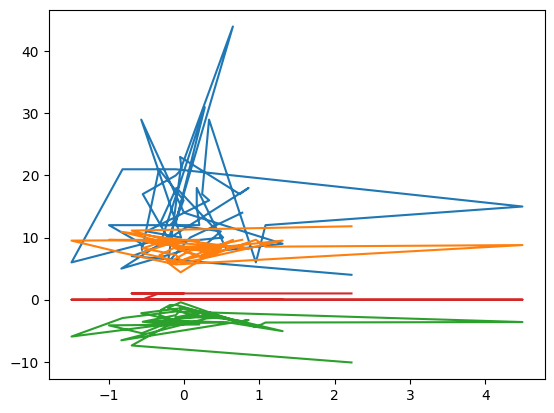

In [298]:
for col in range(4):
    slicer = VectorSlicer(inputCol="features", outputCol='feat', indices = [col])
    output = slicer.transform(test)
    y = to_array(output,'feat')
    plt.plot(x,y)

As we can see from the plot, the error is completely random compared to features

(array([ 2., 12., 24.,  9.,  3.,  0.,  1.,  0.,  0.,  1.]),
 array([-1.4921979 , -0.89375204, -0.29530617,  0.30313969,  0.90158555,
         1.50003141,  2.09847727,  2.69692313,  3.29536899,  3.89381485,
         4.49226071]),
 <BarContainer object of 10 artists>)

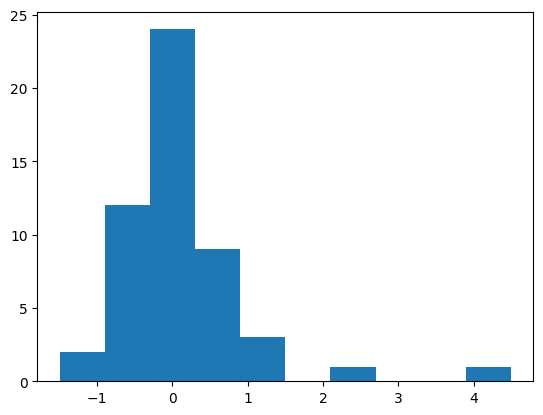

In [301]:
#Now we will if residuals are normally distributed
plt.hist(residuals)

With a few outliers, residuals are close to normally distributed

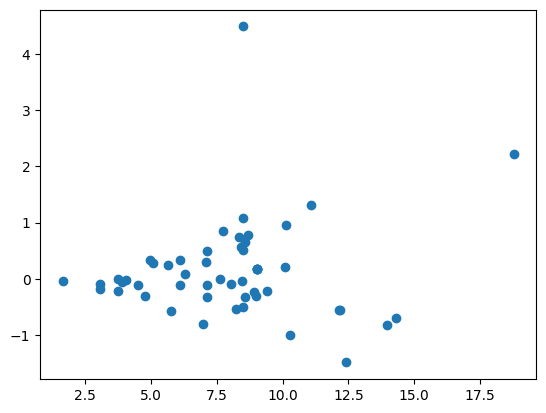

In [303]:
#the last check is for homoscedasticity (i.e. whether the error term is constant along the regression line):
predicted = cvModel.transform(test)
predicted = to_array(predicted,'prediction')
plt.scatter(predicted,residuals)
#From what we can see, the error is approximately the same everywhere

### [Back to table of Contents](#part0)

# Logistic Regression <a class="anchor" id="part2"></a>

### Project Description:
Create a binary classification model to predict customer churn. Dataset:  
Name : Name of the latest contact at Company  
Age: Customer Age  
Total_Purchase: Total Ads Purchased  
Account_Manager: Binary 0=No manager, 1= Account manager assigned  
Years: Totaly Years as a customer  
Num_sites: Number of websites that use the service.  
Onboard_date: Date that the name of the latest contact was onboarded  
Location: Client HQ Address  
Company: Name of Client Company

In [484]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import os

#statistical tests:
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import udf


#data prep/EDA:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql import Window
import pyspark.sql.functions as F

#building a model:

from pyspark.ml.linalg import DenseVector
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [304]:
spark = SparkSession.builder.appName("Logreg").getOrCreate()

In [305]:
spark.sparkContext.setLogLevel('OFF')

In [356]:
path = os.path.join('/Users/test/Desktop/Data_Science/Apache Spark/Python-and-Spark-for-Big-Data-master/Spark_for_Machine_Learning',
                    'Logistic_Regression')
path

'/Users/test/Desktop/Data_Science/Apache Spark/Python-and-Spark-for-Big-Data-master/Spark_for_Machine_Learning/Logistic_Regression'

In [357]:
path = os.path.join(path,'customer_churn.csv')

In [358]:
data = spark.read.csv(train_path, inferSchema = True, header = True)
data.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [359]:
data.show(n=3,vertical = True)
#seems like all data types have been correctly identified by spark. We need to further investigate
#categorical columns "location" and "company" to see if they could be used for the model


-RECORD 0-------------------------------
 Names           | Cameron Williams     
 Age             | 42.0                 
 Total_Purchase  | 11066.8              
 Account_Manager | 0                    
 Years           | 7.22                 
 Num_Sites       | 8.0                  
 Onboard_date    | 2013-08-30 07:00:40  
 Location        | 10265 Elizabeth M... 
 Company         | Harvey LLC           
 Churn           | 1                    
-RECORD 1-------------------------------
 Names           | Kevin Mueller        
 Age             | 41.0                 
 Total_Purchase  | 11916.22             
 Account_Manager | 0                    
 Years           | 6.5                  
 Num_Sites       | 11.0                 
 Onboard_date    | 2013-08-13 00:38:46  
 Location        | 6157 Frank Garden... 
 Company         | Wilson PLC           
 Churn           | 1                    
-RECORD 2-------------------------------
 Names           | Eric Lozano          
 Age            

In [472]:
data.select(['Location']).distinct().count()

900

In [473]:
data.select(['Company']).distinct().count()

873

Both location and company have too many values to be used as a categorical variable for the model. 
We will drop these columns. For now we will keep "Names" column in case we will need to use it as index at a later time.

In [481]:
data = data.drop('Location','Company')

In [482]:
stats = data.summary()

In [483]:
#NUmerical statistics for the dataframe. we will limit the #of decimal points to ensure readability:
stats.select('summary', *(round(col(c)).cast("float").alias(c) for c in stats.columns[1:])).show()

+-------+-----+-----+--------------+---------------+-----+---------+-----+
|summary|Names|  Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+-------+-----+-----+--------------+---------------+-----+---------+-----+
|  count|900.0|900.0|         900.0|          900.0|900.0|    900.0|900.0|
|   mean| null| 42.0|       10063.0|            0.0|  5.0|      9.0|  0.0|
| stddev| null|  6.0|        2409.0|            0.0|  1.0|      2.0|  0.0|
|    min| null| 22.0|         100.0|            0.0|  1.0|      3.0|  0.0|
|    25%| null| 38.0|        8481.0|            0.0|  4.0|      7.0|  0.0|
|    50%| null| 42.0|       10041.0|            0.0|  5.0|      8.0|  0.0|
|    75%| null| 46.0|       11759.0|            1.0|  6.0|     10.0|  0.0|
|    max| null| 65.0|       18026.0|            1.0|  9.0|     14.0|  1.0|
+-------+-----+-----+--------------+---------------+-----+---------+-----+



We can see from the above statistics that there are no missing values. The mean age of a customer is 42 years and the standard deviation is quite small. Most customers do not have an account manager assigned to them, and churned customers represent only a small group of overall customers, which means that we are dealing with an imbalanced dataset. Ww will investigate it further with the help of visualizations.

In [501]:
visual = data.drop('Names').toPandas()

/opt/anaconda3/envs/pyspark/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [503]:
visual

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Churn
0,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,1
1,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,1
2,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,1
3,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,1
4,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,1
...,...,...,...,...,...,...,...
895,42.0,12800.82,1,3.62,8.0,2007-12-01 13:29:34,0
896,52.0,9893.92,0,6.91,7.0,2008-12-28 15:23:58,0
897,45.0,12056.18,0,5.46,4.0,2014-06-20 05:10:09,0
898,51.0,6517.93,1,5.47,10.0,2012-05-30 00:15:43,0


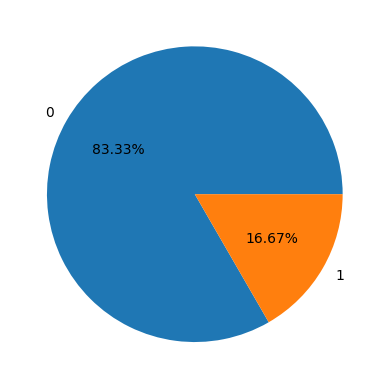

In [522]:
fig,ax = plt.subplots()
ax.pie(visual['Churn'].value_counts(normalize = True),autopct='%1.2f%%', labels = [0,1]);
#As we can see from the pie chart, we have quite a bit of class imbalance, and this will need to be 
#addressed in our model